In [1]:
import pandas as pd

In [2]:
target_df = pd.read_csv('./deribit_split/BTC-9MAY25-92000-P.csv')

In [4]:
target_df

,instrument_name,expiration,strike,option_type,price,amount,direction,timestamp
0,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,9.0,buy,2025-05-06 02:10:59.021
1,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,0.8,buy,2025-05-06 02:10:59.021
2,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,0.3,sell,2025-05-06 02:34:01.707
3,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,1.0,sell,2025-05-06 02:34:17.574
4,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,0.2,sell,2025-05-06 02:35:29.453
...,...,...,...,...,...,...,...,...
106,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0015,0.1,sell,2025-05-07 00:22:15.910
107,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0014,0.1,buy,2025-05-07 01:32:45.873
108,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0016,0.1,buy,2025-05-07 01:46:25.129
109,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0016,0.4,buy,2025-05-07 01:46:25.129


In [7]:
import os
import pandas as pd
from datetime import timedelta
from binance.client import Client

def attach_binance_spot_prices(target_df):
    """
    target_df: 옵션 체결 데이터 (timestamp 컬럼 포함)
    return: spot price가 매핑된 info_df
    """
    # Step 1: 바이낸스 API 연동
    api_key = "zKyYTZWpQC9FfWlaWvbTLkeNENIPt8bBFIwJsMvl2x7pdeC5DI7YEQv9JzJpEEcW"
    api_secret = "lLCEiIcWuip8k529JgBAWXMZXHVHmABTIfRK62oPFjslRhuZcfNmx2IrqwEC0VMH"
    client = Client(api_key, api_secret)

    # Step 2: 필요한 시간 범위 추출
    start_time = target_df['timestamp'].min() - timedelta(minutes=5)
    end_time = target_df['timestamp'].max() + timedelta(minutes=5)

    # Step 3: 바이낸스에서 1분봉 BTCUSDT 데이터 수집
    klines = client.get_historical_klines("BTCUSDT", interval=Client.KLINE_INTERVAL_1MINUTE,
                                          start_str=start_time.strftime("%Y-%m-%d %H:%M:%S"),
                                          end_str=end_time.strftime("%Y-%m-%d %H:%M:%S"))

    spot_df = pd.DataFrame(klines, columns=[
        "timestamp", "open", "high", "low", "close", "volume", "close_time",
        "quote_asset_volume", "number_of_trades", "taker_buy_base",
        "taker_buy_quote", "ignore"
    ])

    spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'], unit='ms')
    spot_df['spot_price'] = spot_df['close'].astype(float)
    spot_df = spot_df[['timestamp', 'spot_price']]

    # Step 4: 가장 가까운 이전 시점의 spot_price를 매핑
    merged_df = pd.merge_asof(
        target_df.sort_values('timestamp'),
        spot_df.sort_values('timestamp'),
        on='timestamp',
        direction='backward'
    )

    return merged_df

In [8]:
final_df = attach_binance_spot_prices(target_df)

In [9]:
final_df

,instrument_name,expiration,strike,option_type,price,amount,direction,timestamp,spot_price
0,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,9.0,buy,2025-05-06 02:10:59.021,94239.76
1,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,0.8,buy,2025-05-06 02:10:59.021,94239.76
2,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,0.3,sell,2025-05-06 02:34:01.707,94173.93
3,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,1.0,sell,2025-05-06 02:34:17.574,94173.93
4,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0055,0.2,sell,2025-05-06 02:35:29.453,94177.49
...,...,...,...,...,...,...,...,...,...
106,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0015,0.1,sell,2025-05-07 00:22:15.910,97461.20
107,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0014,0.1,buy,2025-05-07 01:32:45.873,97505.17
108,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0016,0.1,buy,2025-05-07 01:46:25.129,97304.00
109,BTC-9MAY25-92000-P,2025-05-09 08:00:00,92000.0,put,0.0016,0.4,buy,2025-05-07 01:46:25.129,97304.00


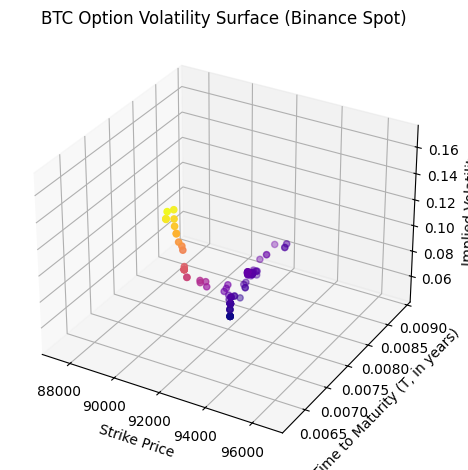

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 실제 데이터가 있다고 가정하고, 시각화용으로 데이터 준비
df = final_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['expiration'] = pd.to_datetime(df['expiration'])
df['T'] = (df['expiration'] - df['timestamp']).dt.total_seconds() / (365 * 24 * 60 * 60)

# IV 계산 함수
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(price, S, K, T, r, option_type='call'):
    from scipy.optimize import brentq
    try:
        return brentq(lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - price, 1e-6, 5.0)
    except:
        return np.nan

# 무위험이자율 설정
r = 0.01

# IV 계산
df['IV'] = df.apply(lambda row: implied_volatility(
    price=row['price'],
    S=row['spot_price'],
    K=row['strike'],
    T=row['T'],
    r=r,
    option_type=row['option_type']
), axis=1)

# 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['strike']
y = df['T']
z = df['IV']

ax.scatter(x, y, z, c=z, cmap='plasma')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity (T, in years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('BTC Option Volatility Surface (Binance Spot)')

plt.tight_layout()
plt.show()


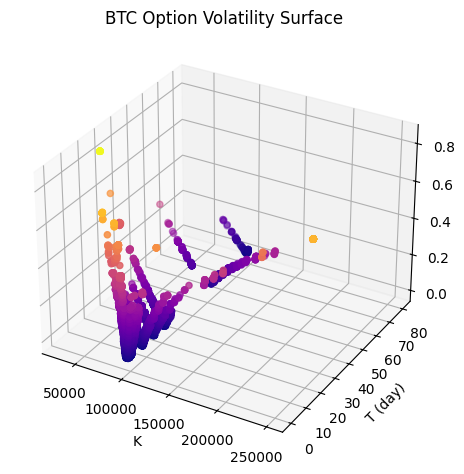

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from binance.client import Client
from scipy.stats import norm
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Binance 스팟 가격 붙이는 함수
def attach_binance_spot_prices(target_df, api_key, api_secret):
    client = Client(api_key, api_secret)
    start_time = target_df['timestamp'].min() - timedelta(minutes=5)
    end_time = target_df['timestamp'].max() + timedelta(minutes=5)

    klines = client.get_historical_klines("BTCUSDT", interval=Client.KLINE_INTERVAL_1MINUTE,
                                          start_str=start_time.strftime("%Y-%m-%d %H:%M:%S"),
                                          end_str=end_time.strftime("%Y-%m-%d %H:%M:%S"))

    spot_df = pd.DataFrame(klines, columns=[
        "timestamp", "open", "high", "low", "close", "volume", "close_time",
        "quote_asset_volume", "number_of_trades", "taker_buy_base",
        "taker_buy_quote", "ignore"
    ])
    spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'], unit='ms')
    spot_df['spot_price'] = spot_df['close'].astype(float)
    spot_df = spot_df[['timestamp', 'spot_price']]

    merged_df = pd.merge_asof(
        target_df.sort_values('timestamp'),
        spot_df.sort_values('timestamp'),
        on='timestamp',
        direction='backward'
    )

    return merged_df

# Step 2: Black-Scholes 가격 및 IV 계산
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(price, S, K, T, r, option_type='call'):
    try:
        return brentq(lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - price, 1e-6, 5.0)
    except:
        return np.nan

# Step 3: 옵션 CSV 병합
def load_and_merge_option_data(folder_path):
    all_dfs = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv") and file.startswith("BTC-"):
            df = pd.read_csv(os.path.join(folder_path, file))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df['expiration'] = pd.to_datetime(df['expiration'])
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)

# Step 4: 전체 파이프라인 실행
def process_and_plot_vol_surface(folder_path, api_key, api_secret):
    df = load_and_merge_option_data(folder_path)
    df = attach_binance_spot_prices(df, api_key, api_secret)

    # ✅ T를 '일 단위'로 표현
    df['T_days'] = (df['expiration'] - df['timestamp']).dt.total_seconds() / (60 * 60 * 24)

    # IV 계산을 위해선 여전히 '연 단위' T 사용
    df['T_years'] = df['T_days'] / 365

    r = 0.01  # 무위험 금리

    df['IV'] = df.apply(lambda row: implied_volatility(
        price=row['price'],
        S=row['spot_price'],
        K=row['strike'],
        T=row['T_years'],
        r=r,
        option_type=row['option_type']
    ), axis=1)

    # Step 5: 시각화 (T_days를 Y축으로)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = df['strike']
    y = df['T_days']
    z = df['IV']

    ax.scatter(x, y, z, c=z, cmap='plasma')
    ax.set_xlabel('K')
    ax.set_ylabel('T (day)')
    ax.set_zlabel('IV')
    ax.set_title('BTC Option Volatility Surface')
    plt.tight_layout()
    plt.show()


# 📌 여기에 실제로 실행하려면 아래 코드를 사용 (키는 환경변수 또는 직접 입력 필요)
process_and_plot_vol_surface(
    folder_path="./deribit_split",
    api_key="zKyYTZWpQC9FfWlaWvbTLkeNENIPt8bBFIwJsMvl2x7pdeC5DI7YEQv9JzJpEEcW",
    api_secret="lLCEiIcWuip8k529JgBAWXMZXHVHmABTIfRK62oPFjslRhuZcfNmx2IrqwEC0VMH"
)

